In [3]:
# Standard Libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Notebook aesthetics
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

# Load cleaned dataset (from Phase 3)
df = pd.read_csv('Data1/cleaned_sales.csv', parse_dates=['orderdate'])

# Quick check
df.head()


,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,status,qtr_id,month_id,year_id,...,country,territory,contactlastname,contactfirstname,dealsize,cost_each,profit_est,discount_pct,inventory_age_days,is_profitable
0,10100,49,34.47,1,1689.03,2003-01-06,Shipped,1,1,2003,...,USA,NaN,Young,Valarie,Small,24.6,483.63,0.1593,276.0,1
1,10100,50,67.80,2,3390.00,2003-01-06,Shipped,1,1,2003,...,USA,NaN,Young,Valarie,Medium,36.0,1590.00,-0.1300,339.0,1
2,10100,30,100.00,3,5151.00,2003-01-06,Shipped,1,1,2003,...,USA,NaN,Young,Valarie,Medium,102.0,-60.00,0.4118,138.0,0
3,10100,22,86.51,4,1903.22,2003-01-06,Shipped,1,1,2003,...,USA,NaN,Young,Valarie,Small,55.2,688.82,0.0597,40.0,1
4,10101,26,100.00,1,3773.38,2003-01-09,Shipped,1,1,2003,...,Germany,EMEA,Keitel,Roland,Medium,100.8,-20.80,0.4048,152.0,0


In [4]:
print("Shape of dataset:", df.shape)
print(df.info())
print(df.describe().T)

# Check missing values
print(df.isnull().sum())

# Check duplicates
print("Duplicate rows:", df.duplicated().sum())


Shape of dataset: (2823, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   ordernumber         2823 non-null   int64         
 1   quantityordered     2823 non-null   int64         
 2   priceeach           2823 non-null   float64       
 3   orderlinenumber     2823 non-null   int64         
 4   sales               2823 non-null   float64       
 5   orderdate           2823 non-null   datetime64[ns]
 6   status              2823 non-null   object        
 7   qtr_id              2823 non-null   int64         
 8   month_id            2823 non-null   int64         
 9   year_id             2823 non-null   int64         
 10  productline         2823 non-null   object        
 11  msrp                2823 non-null   float64       
 12  productcode         2823 non-null   object        
 13  customername       

In [5]:
# Ensure numeric
df['quantityordered'] = pd.to_numeric(df['quantityordered'], errors='coerce').fillna(0)
df['priceeach'] = pd.to_numeric(df['priceeach'], errors='coerce').fillna(0)
df['msrp'] = pd.to_numeric(df['msrp'], errors='coerce').fillna(0)

# Compute cost assumption
df['cost_each'] = df['msrp'] * 0.6

# Derive profit
df['profit'] = (df['priceeach'] - df['cost_each']) * df['quantityordered']

# Derive discount %
df['discount_pct'] = np.where(df['msrp'] > 0, 
                              (df['msrp'] - df['priceeach']) / df['msrp'], 
                              0)

# Double-check
print(df[['sales','profit','discount_pct']].head())

     sales   profit  discount_pct
0  1689.03   483.63      0.159268
1  3390.00  1590.00     -0.130000
2  5151.00   -60.00      0.411765
3  1903.22   688.82      0.059674
4  3773.38   -20.80      0.404762


{'Total Sales': 10032628.85, 'Total Profit': 2292481.59, 'Avg Margin %': 22.85, 'Total Orders': 307, 'Unique SKUs': 109, 'Unique Customers': 92}


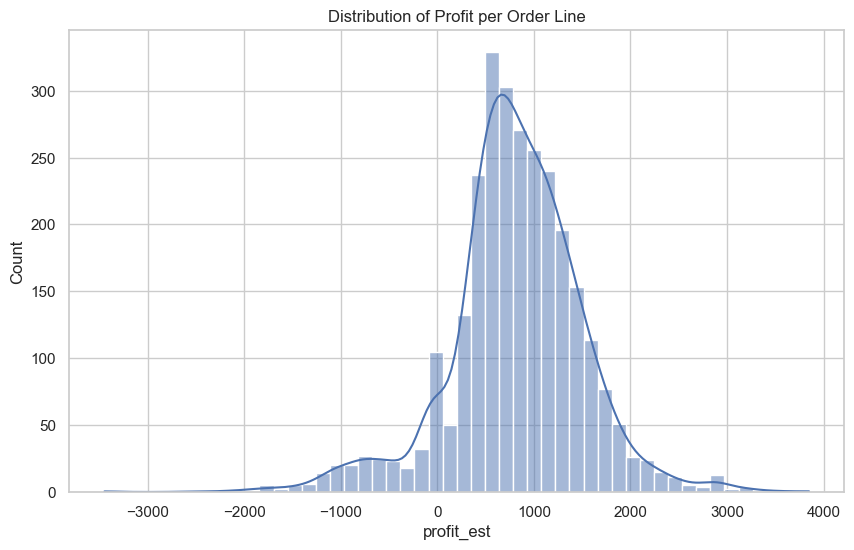

In [6]:
kpi = {
    "Total Sales": df['sales'].sum(),
    "Total Profit": df['profit_est'].sum(),
    "Avg Margin %": round((df['profit_est'].sum() / df['sales'].sum()) * 100, 2),
    "Total Orders": df['ordernumber'].nunique(),
    "Unique SKUs": df['productcode'].nunique(),
    "Unique Customers": df['customername'].nunique()
}
print(kpi)

# Profit distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['profit_est'], bins=50, kde=True)
plt.title("Distribution of Profit per Order Line")
plt.show()

In [7]:
import pandas as pd
import plotly.express as px

# Ensure datetime conversion
df['orderdate'] = pd.to_datetime(df['orderdate'])

# Extract monthly period
df['order_month'] = df['orderdate'].dt.to_period('M').dt.to_timestamp()

# Group sales & profit by month
monthly = df.groupby('order_month')[['sales','profit']].sum().reset_index()

# Plot interactive line chart
fig = px.line(
    monthly,
    x='order_month',
    y=['sales','profit'],
    title="Monthly Sales & Profit Trends"
)

fig.show()


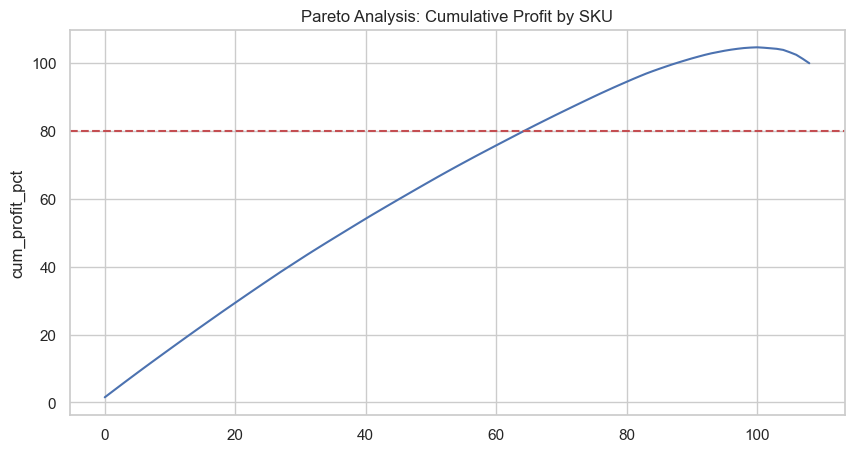

In [8]:
sku_profit = df.groupby('productcode')['profit'].sum().reset_index()
sku_profit = sku_profit.sort_values(by='profit', ascending=False)
sku_profit['cum_profit_pct'] = sku_profit['profit'].cumsum() / sku_profit['profit'].sum() * 100

plt.figure(figsize=(10,5))
sns.lineplot(data=sku_profit, x=range(len(sku_profit)), y='cum_profit_pct')
plt.axhline(80, color='r', linestyle='--')
plt.title("Pareto Analysis: Cumulative Profit by SKU")
plt.show()


In [9]:
terr = df.groupby('territory')[['sales','profit']].sum().reset_index()

fig = px.bar(terr, x='territory', y='profit', color='sales', 
             title="Profit & Sales by Territory")
fig.show()


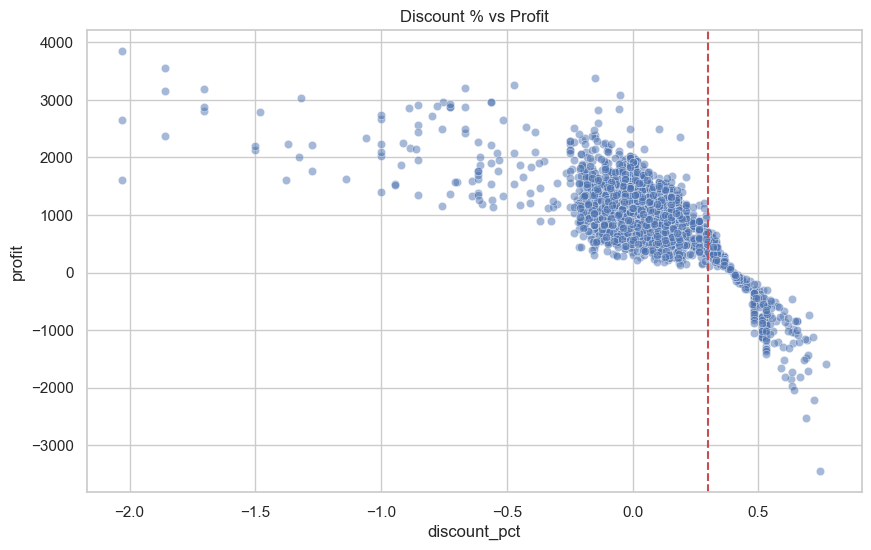

In [10]:
sns.scatterplot(data=df, x='discount_pct', y='profit', alpha=0.5)
plt.axvline(0.3, color='r', linestyle='--')
plt.title("Discount % vs Profit")
plt.show()


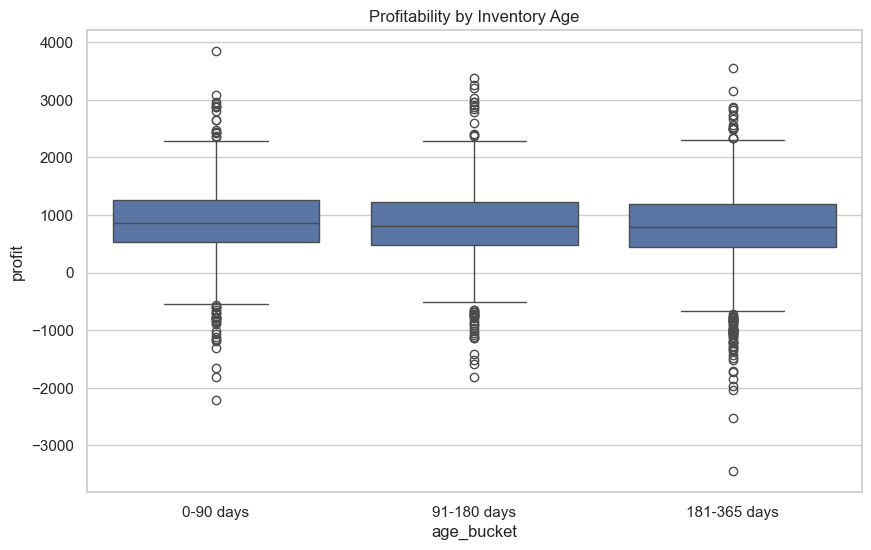

In [11]:
df['age_bucket'] = pd.cut(df['inventory_age_days'], bins=[0,90,180,365], 
                          labels=["0-90 days","91-180 days","181-365 days"])

sns.boxplot(data=df, x='age_bucket', y='profit')
plt.title("Profitability by Inventory Age")
plt.show()
